# Classifying hands poses with Kendall shape spaces

The goal of this notebook is to showcase how geometric and topological methods are used to perform hand poses recognition.

We study the difference between two classes of data:
- hand poses that correspond to the action "Grab",
- hand poses heads that correspond to the action "Expand".

The hand poses are represented as the coordinates of 22 joints in 3D, as shown in Figure 1.

<img src="hand_skeleton.png" width=300 height=300/>
Figure 1. Hand poses are represented by the coordinates of the 22 joints of their skeletons. Image credits: http://www-rech.telecom-lille.fr/shrec2017-hand/.

# 1. Introduction and Motivation

Human-computer interaction (HCI) still mostly leverages the use of mouses and keyboards. In recent years however, computer-vision methods have been used to detect and recognize human gestures, including hand poses and movements, for a wide variety of tasks ranging from understanding sign language, gaming, medical applications and controlling augmented or virtual reality devices. These developments have led to new types of HCI, as hand gestures and poses can be a marker of language, physical behavior and intentions and even emotional expression.

This notebook studies and compares different methods for (static) hand poses classification and clustering.

# 2. Analysis

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import geomstats.visualization as visualization
import geomstats.backend as gs
import geomstats.datasets.utils as data_utils
from geomstats.geometry.pre_shape import PreShapeSpace, KendallShapeMetric

visualization.tutorial_matplotlib()

INFO: Using numpy backend


## 2.1. Dataset description

We consider a public dataset of hand poses, where a hand is represented as a set of 22 "landmarks" - the hands joints - in 3D. The dataset is a subset of the SHREC 2017 dataset (SWVGLF2017).

The hand poses belong to one of two classes:
- Label 0: hand is in the position "Grab",
- Label 1: hand is in the position "Expand".

##### Reference
(SWVGLF2017) Q. De Smedt, H. Wannous, J.P. Vandeborre, 
J. Guerry, B. Le Saux, D. Filliat, SHREC'17 Track: 3D Hand Gesture 
Recognition Using a Depth and Skeletal Dataset, 10th Eurographics 
Workshop on 3D Object Retrieval, 2017.
https://doi.org/10.2312/3dor.20171049

We load the dataset of landmarks' sets and corresponding labels.

In [3]:
hands, labels, bone_list = data_utils.load_hands()

In [4]:
n_hands, k_landmarks, dim = hands.shape
print(hands.shape)
print(labels)

(52, 22, 3)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


To brieflyl visualize and explore this dataset, we extract two hands, one corresponding to the "Grab" pose, and the other to the "Expand" pose.

In [5]:
label_to_str = {0: 'Grab', 1: 'Expand'}
label_to_color = {0: (102/255, 178/255, 255/255, 1.), 1: (255/255, 178/255, 102/255, 1.)}
first_grab_hand = hands[labels==0][0]
first_expand_hand = hands[labels==1][0]

We implement a function to plot one hand in 3D.

In [6]:
def plot_hand(hand, bone_list):
    fig = plt.figure()
    ax = plt.axes(projection="3d")

    x = hand[:, 0]
    y = hand[:, 1]
    z = hand[:, 2]

    sc = ax.scatter(x, y, z, s=40)
    for bone in bone_list:
        start_bone_idx = bone[0]
        end_bone_idx = bone[1]
        ax.plot(
            xs=[x[start_bone_idx], x[end_bone_idx]],
            ys=[y[start_bone_idx], y[end_bone_idx]],
            zs=[z[start_bone_idx], z[end_bone_idx]],
        )

We plot two examples of hands.

<IPython.core.display.Javascript object>


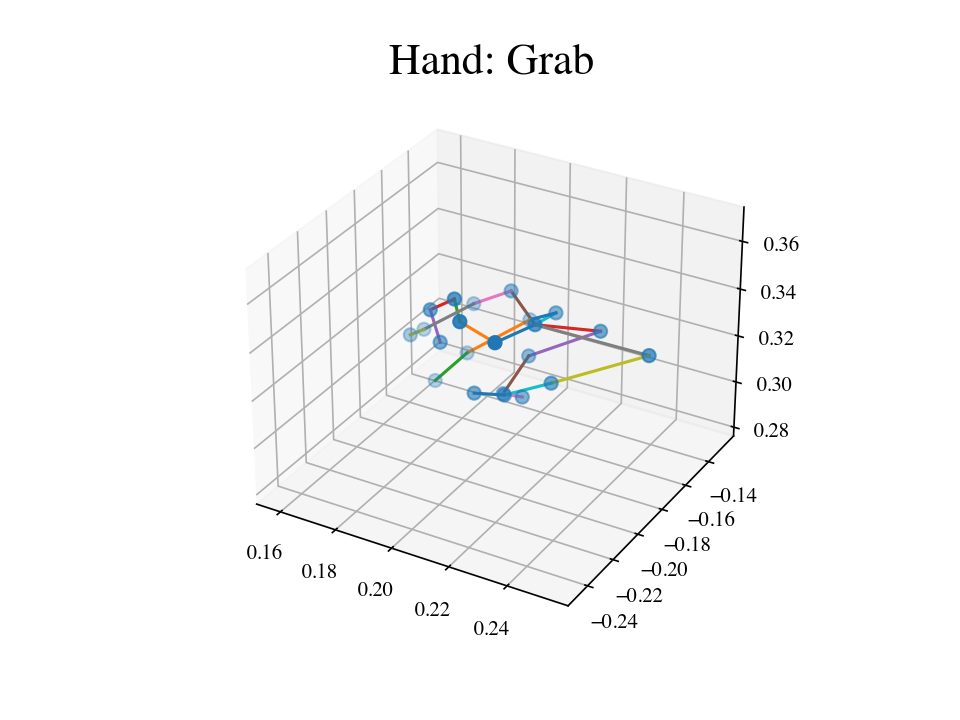

<IPython.core.display.Javascript object>


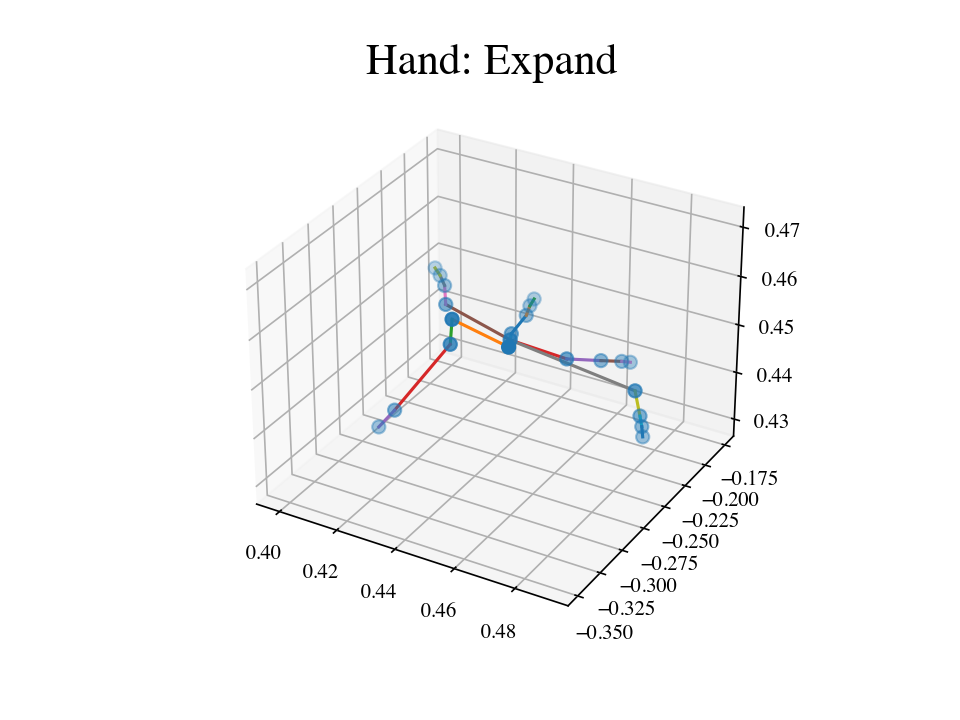

In [7]:
%matplotlib notebook

plot_hand(first_grab_hand, bone_list)
plt.title(f"Hand: {label_to_str[0]}")
plot_hand(first_expand_hand, bone_list)
plt.title(f"Hand: {label_to_str[1]}");

## 2.2. Classification and clustering using 3D coordinates

We first consider the most intuitive approach, which considers the hand poses as the list of their joint coordinates in 3D without explicitly extracting any notion of size or shape.

We perform a logistic regression with cross-validation (5 folds). We test two clustering algorithms: Kmeans and Agglomerative Clustering.

In [8]:
hands_flatten = np.reshape(hands, (n_hands, -1))

X_train, X_test, y_train, y_test = train_test_split(
    hands_flatten, labels, test_size=0.2, random_state=0)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
pred_labels = logreg.predict(X_test)

print(f"True labels: {y_test}")
print(f"Predicted labels: {pred_labels}")

logreg_accuracy = np.sum(pred_labels == y_test) / len(y_test)
logreg_accuracy

Train set: (41, 66), (41,)
Test set: (11, 66), (11,)
True labels: [1 1 0 1 0 1 1 1 1 0 0]
Predicted labels: [1 1 0 0 0 1 0 1 1 0 0]


0.8181818181818182

The accuracy gives us a baseline accuracy, that we can try to improve.

We continue by trying clustering methods, i.e. attempting to recognize the hand poses without supervision.

In [9]:
est = KMeans(n_clusters=2, n_init=1, init='random')

est.fit(hands_flatten)
est_labels = est.labels_
print(f"True labels: {labels}")
print(f"Estimated labels: {est_labels}")
kmeans_accuracy = np.sum(est_labels == labels) / n_hands
kmeans_accuracy

True labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Estimated labels: [0 1 0 0 1 1 0 0 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 0 0 0 1
 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1]


0.4807692307692308

<IPython.core.display.Javascript object>


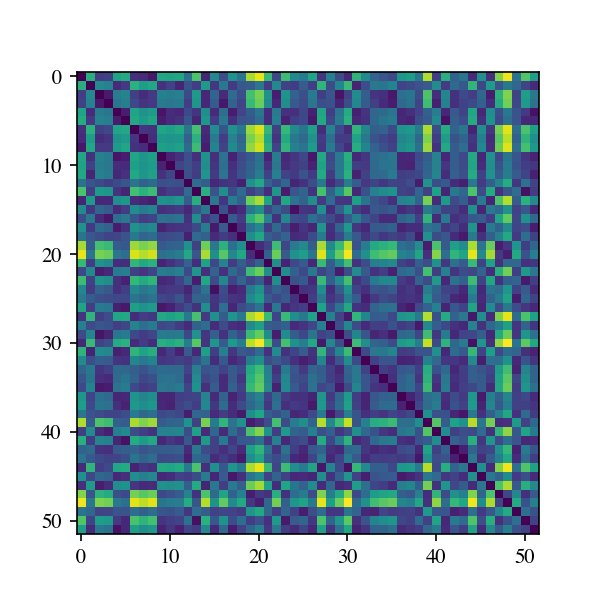

In [10]:
from geomstats.geometry.euclidean import EuclideanMetric

eucl_metric = EuclideanMetric(dim * k_landmarks)
eucl_pair_dist = eucl_metric.dist_pairwise(hands_flatten)

plt.figure(figsize=(4, 4))
plt.imshow(eucl_pair_dist);

In [12]:
clustering = AgglomerativeClustering(
    affinity="precomputed", linkage="average")

clustering.fit(eucl_pair_dist)
est_labels = clustering.labels_

print(f"True labels: {labels}")
print(f"Estimated labels: {est_labels}")

agg_accuracy = np.sum(est_labels == labels) / n_hands
agg_accuracy

True labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Estimated labels: [1 0 1 1 0 0 1 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 1 1 0
 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0]


0.46153846153846156

In [13]:
hands_result = {
    "data": "hands", 
    "logistic regression": logreg_accuracy,
    "kmeans": kmeans_accuracy,
    "agglomerative clustering": agg_accuracy}

## 2.2. Classification and clustering using sizes

We want to investigate if there is a difference between these two groups of shapes - grab versus expand - or if the main difference is merely relative to the global size of the landmarks' sets.

<IPython.core.display.Javascript object>


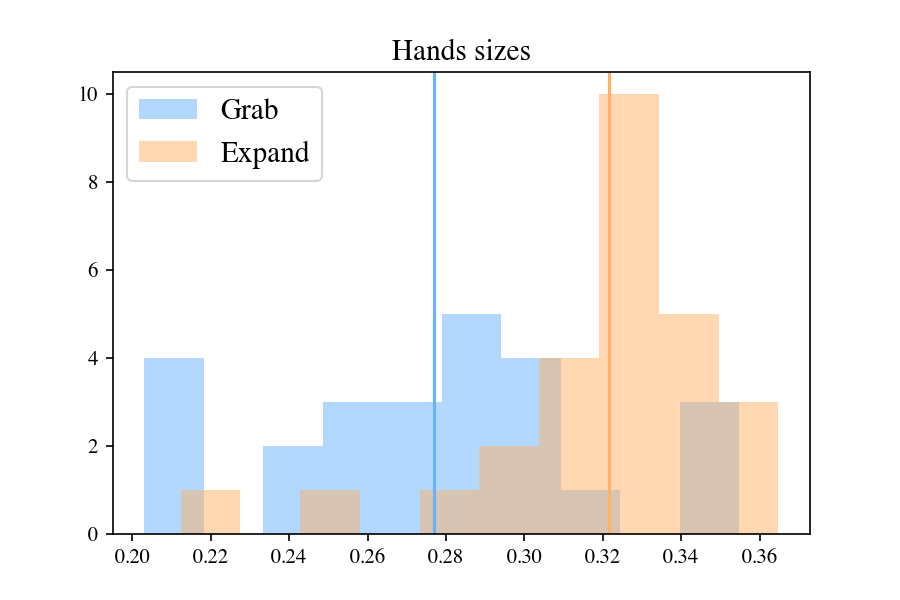

In [14]:
preshape = PreShapeSpace(m_ambient=dim, k_landmarks=k_landmarks)
matrices_metric = preshape.embedding_metric

sizes = matrices_metric.norm(preshape.center(hands))

plt.figure(figsize=(6, 4))
for label, col in label_to_color.items():
    label_sizes = sizes[labels==label]
    plt.hist(label_sizes, color=col, label=label_to_str[label], alpha=0.5, bins=10)
    plt.axvline(gs.mean(label_sizes),  color=col)
plt.legend(fontsize=14)
plt.title('Hands sizes', fontsize=14);

We perform a hypothesis test, testing if the two samples of sizes have the same average.

In [15]:
from scipy import stats

signif_level = 0.05

tstat, pvalue = stats.ttest_ind(sizes[labels==0], sizes[labels==1])
print(pvalue < signif_level)

True


The size could be a characteristic allowing to distinguish between these two specific shapes. We perform a logistic regression with cross-validation, and print the accuracy. Accuracy is defined as the fraction of correct predictions: 
$$A = \frac{\text{Correct predictions}}{\text{total number of data points}}.$$

In [16]:
if sizes.ndim == 1:
    sizes = np.expand_dims(sizes, axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    sizes, labels, test_size=0.2, random_state=0)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
pred_labels = logreg.predict(X_test)

print(f"True labels: {y_test}")
print(f"Predicted labels: {pred_labels}")

logreg_accuracy = np.sum(pred_labels == y_test) / len(y_test)
logreg_accuracy

Train set: (41, 1), (41,)
Test set: (11, 1), (11,)
True labels: [1 1 0 1 0 1 1 1 1 0 0]
Predicted labels: [0 0 0 0 0 0 0 0 0 0 0]


0.36363636363636365

In [17]:
est = KMeans(n_clusters=2, n_init=1, init='random')

est.fit(sizes)
est_labels = est.labels_

kmeans_accuracy = np.sum(est_labels == labels) / n_hands
kmeans_accuracy

0.7307692307692307

In [18]:
clustering = AgglomerativeClustering(linkage="average")

clustering.fit(sizes)
est_labels = clustering.labels_

agg_accuracy = np.sum(est_labels == labels) / n_hands
agg_accuracy

0.4230769230769231

In [20]:
sizes_result = {
    "data": "sizes", 
    "logistic regression": logreg_accuracy,
    "kmeans": kmeans_accuracy,
    "agglomerative clustering": agg_accuracy}

## 2.3. Clustering in Kendall shape space

We want to investigate if there is a difference in shapes, where the size component has been quotiented out. 

We project the data to the Kendall pre-shape space, which:
- centers the hand landmark sets so that they share the same barycenter,
- normalizes the sizes of the landmarks' sets to 1.

In [21]:
hands_preshape = preshape.projection(hands)
print(hands_preshape.shape)
print(preshape.belongs(hands_preshape))
print(gs.isclose(matrices_metric.norm(hands_preshape), 1.))

(52, 22, 3)
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


In order to quotient out the 3D orientation component, we align the landmark sets in the preshape space. 

In [22]:
base_point = hands_preshape[0]

hands_shape = preshape.align(point=hands_preshape, base_point=base_point)
print(hands_shape.shape)

(52, 22, 3)


The Kendall metric is a Riemannian metric that takes this alignment into account. It corresponds to the metric of the Kendall shape space, which is the manifold defined as the preshape space quotient by the action of the rotation in m_ambient dimensions, here in 3 dimensions.

In [23]:
kendall_metric = KendallShapeMetric(m_ambient=dim, k_landmarks=k_landmarks)

We can use it to perform a tangent PCA in the Kendall shape space, and determine if we see a difference in the hand shapes.

<IPython.core.display.Javascript object>


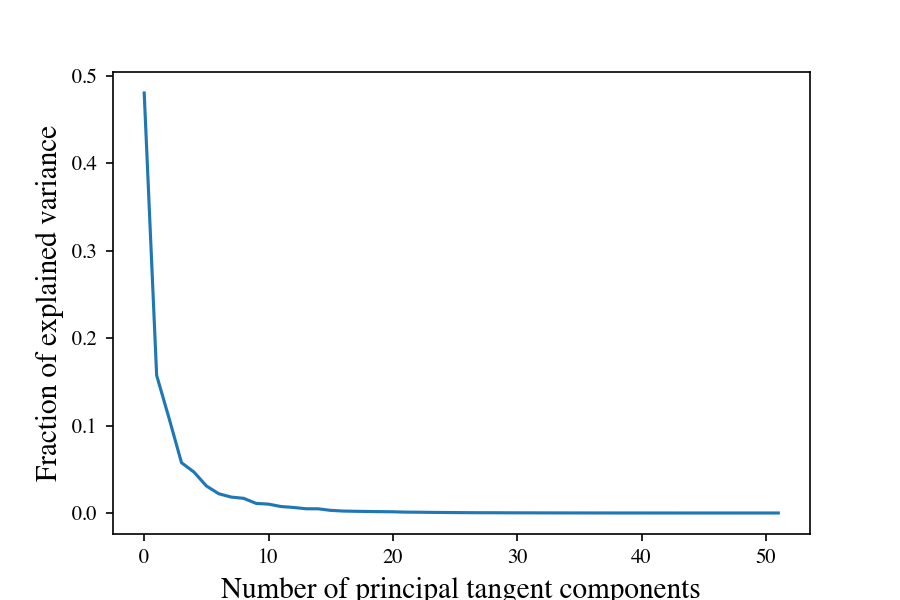

In [24]:
from geomstats.learning.pca import TangentPCA

tpca = TangentPCA(kendall_metric)
tpca.fit(hands_shape)

plt.figure(figsize=(6, 4))
plt.plot(
    tpca.explained_variance_ratio_)
plt.xlabel("Number of principal tangent components", size=14)
plt.ylabel("Fraction of explained variance", size=14);

The first 2 principal components capture around 60% of the variance.

<IPython.core.display.Javascript object>


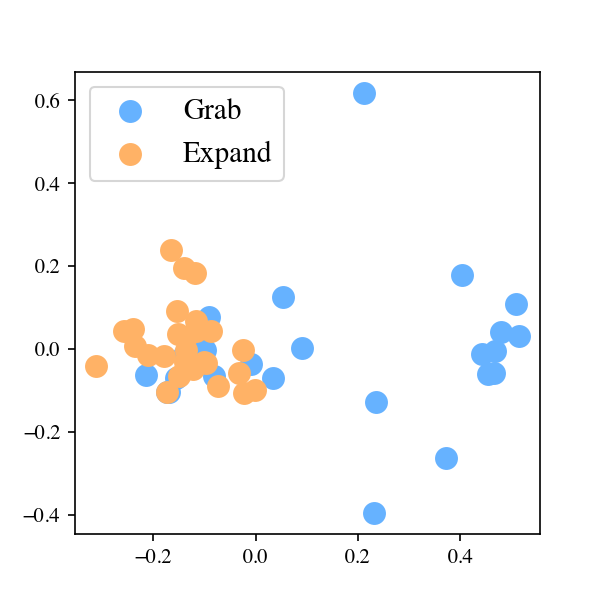

In [25]:
X = tpca.transform(hands_shape)

plt.figure(figsize=(4, 4))

for label, col in label_to_color.items():
    mask = labels == label
    plt.scatter(X[mask, 0], X[mask, 1], color=col, s=100, label=label_to_str[label]);
plt.legend(fontsize=14);

In [26]:
kendall_pair_dist = kendall_metric.dist_pairwise(hands_shape)
print(kendall_pair_dist.shape)

(52, 52)


<IPython.core.display.Javascript object>


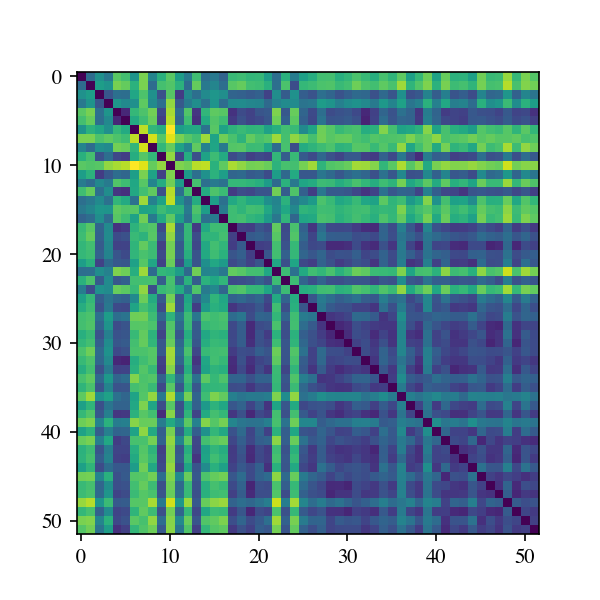

In [27]:
plt.figure(figsize=(4, 4))
plt.imshow(kendall_pair_dist);

This distance matrix can now be used to perform clustering on the hands shapes.

In [28]:
clustering = AgglomerativeClustering(
    affinity="precomputed", linkage="average")

clustering.fit(kendall_pair_dist)
est_labels = clustering.labels_

agg_accuracy = np.sum(est_labels == labels) / n_hands
agg_accuracy

0.46153846153846156

In [29]:
shapes_result = {
    "data": "shapes", "agglomerative clustering": agg_accuracy}

## 2.4. Central role of Geomstats/Giotto-TDA

`Geomstats` plays a central role in this analysis, first by providing the test dataset of hand poses. Then, the computations relying on hand shapes as opposed to hands landmarks coordinates are run seemlessly with `geomstats`. Lastly, the computations of the distances between shapes is performed using the Kendall shape spaces provided by `geomstats`.

# 3. Benchmark

We compare the methods in terms of accuracy only. We summarize the results in a dataframe.

In [30]:
results = pd.DataFrame([hands_result, sizes_result, shapes_result])
results

,data,logistic regression,kmeans,agglomerative clustering
0,hands,0.818182,0.480769,0.461538
1,sizes,0.363636,0.730769,0.423077
2,shapes,NaN,NaN,0.461538


Interestingly, the two supervised methods (logistic regressions on hand landmarks and sizes) perform drastically differently. The sizes do not seem to have enough information to allow classifying the hand poses.

Most unsupervised clustering methods have an accuracy around 50%, i.e. equivalent to the random guessing technique. None of the hand poses features considered seem to convey enough information to distinguish between the two groups.

Overall, the non-geometry methods perform either better or equivalently to the standard methods. It does not seem that there is a clear advantage of using geometric methods in this specific case.

# 4. Limitations and Perspectives

## Limitations of the methods and experiments

The experiments conducted were probably too limited to make any relevant conclusion about the differences between non-geometric and geometric methods. In particular, only a few basic supervised and unsupervised learning methods have been used, and no cross-validation has been performed. More extensive experiments should be run to better highlight the differences between the two classes of methods.

Furthermore, we did not perform any benchmark in terms of the methods' speed. Efficiency of each method should be taken into account in further works in order to give a clearer picture.

## Limitations of the packages Geomstats/Giotto-TDA

Since the geometric methods did not seem provide any accuracy gain, it is unclear how the Kendall shape spaces of `geomstats` can make a difference in such analysis.

## List of desirable features in Geomstats/Giotto-TDA

It would be helpful to see an example using `geomstats` where using Kendall shape spaces makes a difference (either in accuracy or speed of the analysis) in the data analysis, as opposed to using standard scikit-learn method.

Furthermore, there is no profiling of the code in `geomstats`. It would be interesting from a user perspective to understand the efficiency of several `geomstats` functions.